- [ ] Try to overfit earlier
    * Try adding more layers

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline

## Load data

In [4]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X = np.concatenate((TDC, IDD))
Y = [0]*len(TDC) + [1]*len(IDD)
Y = np.asarray(Y)

In [5]:
print(X.shape)
print(Y.shape)

(8470, 14, 256)
(8470,)


## Create Spectrograms

In [6]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm.real.astype("float64")

In [7]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="float64")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [9]:
X_scalogram = generate_scalogram(X, 128, 64, 2)

100%|██████████| 8470/8470 [04:12<00:00, 33.59it/s]


In [10]:
X_scalogram.shape

(8470, 448, 128)

In [11]:
def plot_scalograms(data, sample_index, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (14 * (fs / 2)), (14 * int(hz / 2)))
    
    print("Y label:", Y[sample_index])
    
    plt.rcParams['figure.figsize'] = 14, 30
    im = plt.pcolormesh(t, freq, np.abs(data[sample_index]), cmap = 'jet') # 'viridis'
    plt.show()


Y label: 0


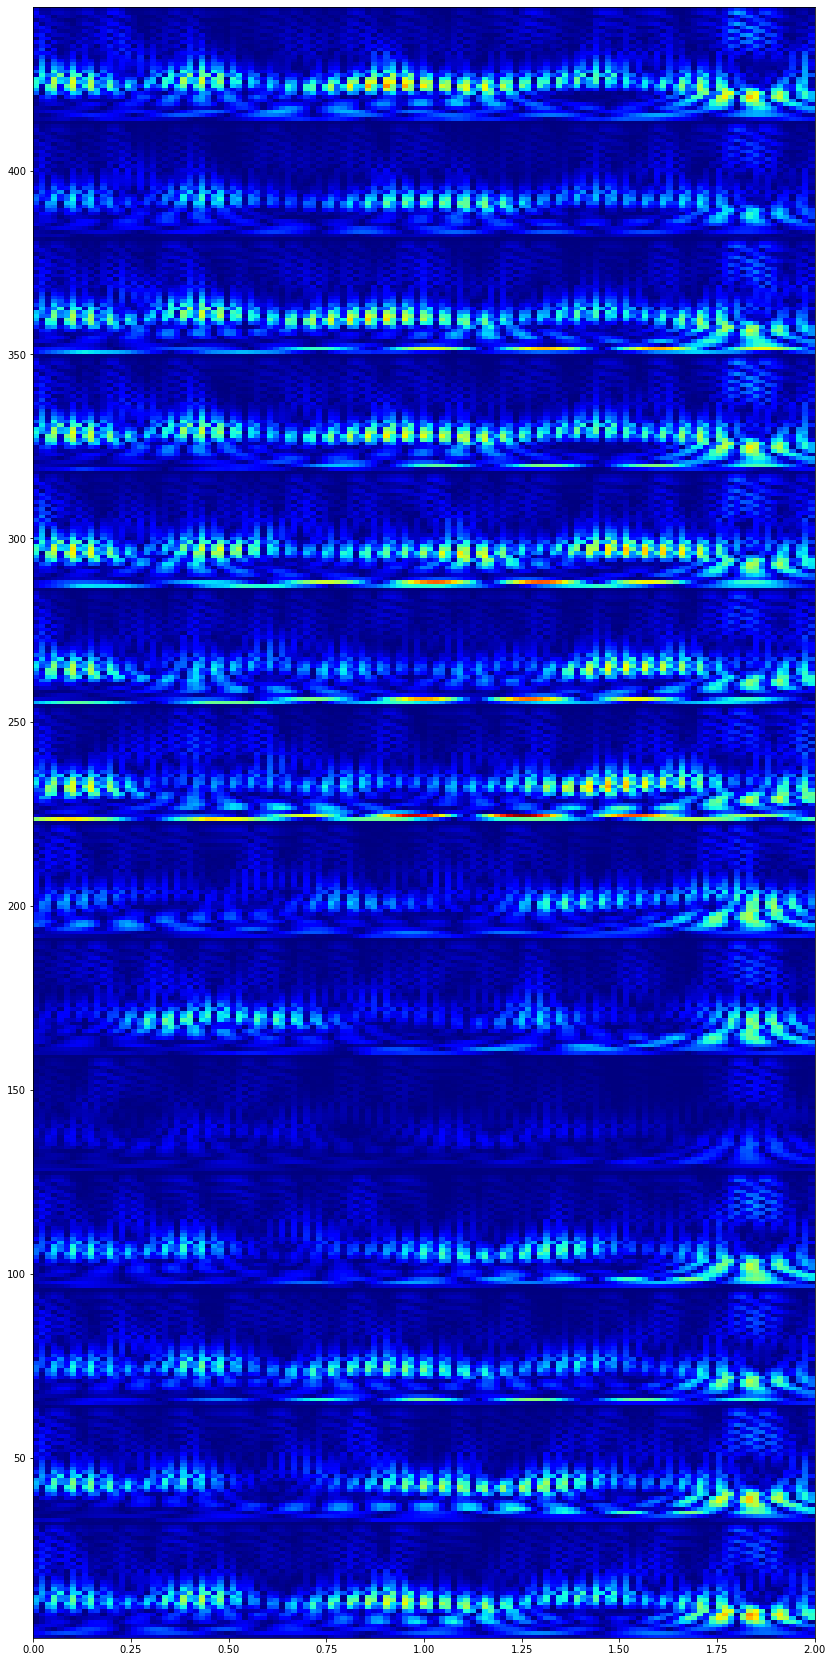

In [12]:
plot_scalograms(X_scalogram, 2000)

In [13]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1] * X_scalogram.shape[2])
X_scalogram_shaped.shape

(8470, 57344)

## Test-Train split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, stratify=Y, random_state=42)

In [15]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
input_shape = X_train.shape[1]
print("input_shape:", input_shape)

X_train shape: (6776, 57344)
y_train shape: (6776,)
X_val shape: (1694, 57344)
y_val shape: (1694,)
input_shape: 57344


## Model

### Sklearn

In [16]:
clf = LogisticRegression(solver='saga',
                         multi_class='ovr', 
                         verbose=1).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 315 seconds


/Users/koda/opt/anaconda3/envs/ms_project/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


In [17]:
score = clf.score(X_val, y_val)  
print(score)

0.48288075560802834


In [18]:
from sklearn import metrics
predictions = clf.predict(X_val)
cm = metrics.confusion_matrix(y_val, predictions)  
print(cm)

[[431 416]
 [460 387]]


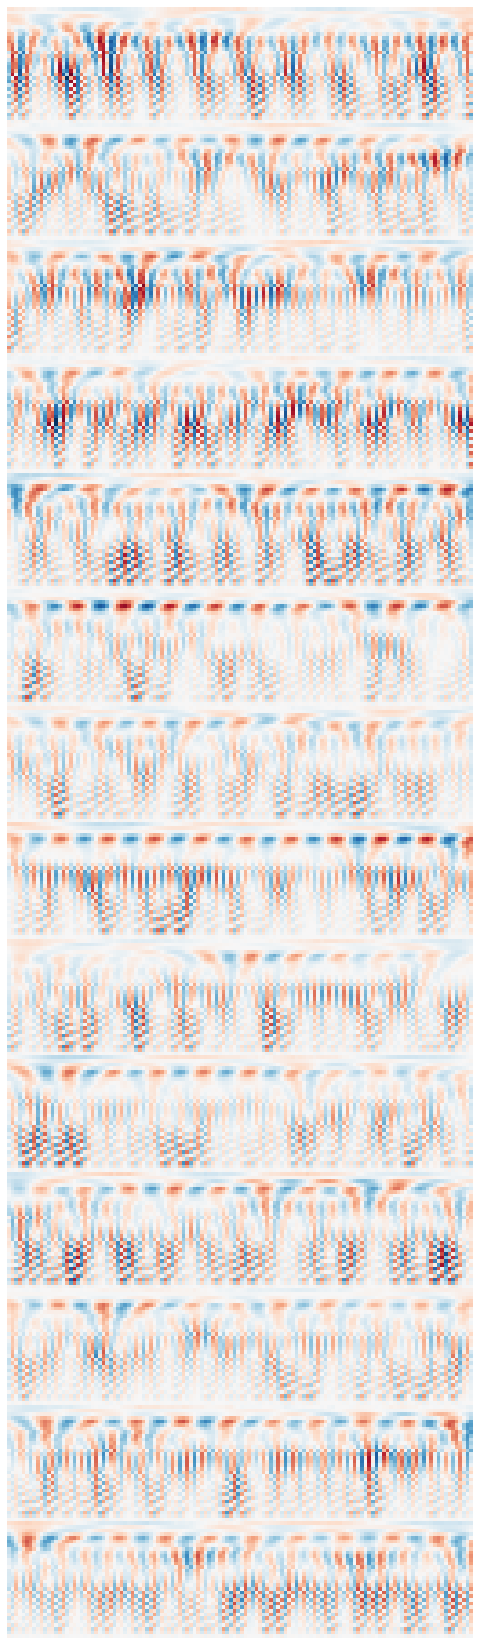

In [19]:
nclasses = 1

scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 30));

p = plt.imshow(clf.coef_[0].reshape(448, 128),
              cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
p = plt.axis('off')

### Keras

In [28]:
model1 = keras.Sequential([
    keras.layers.Dense(1, input_dim=input_shape, activation=tf.nn.sigmoid)
])

model1.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 57345     
Total params: 57,345
Trainable params: 57,345
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model1.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6776 samples, validate on 1694 samples
Epoch 1/10
6776/6776 [==============================] - 2s 327us/sample - loss: 11.5440 - accuracy: 0.4888 - val_loss: 13.0520 - val_accuracy: 0.4847
Epoch 2/10
6776/6776 [==============================] - 1s 195us/sample - loss: 9.3820 - accuracy: 0.5503 - val_loss: 11.5149 - val_accuracy: 0.4852
Epoch 3/10
6776/6776 [==============================] - 1s 212us/sample - loss: 8.5020 - accuracy: 0.5629 - val_loss: 11.2607 - val_accuracy: 0.4911
Epoch 4/10
6776/6776 [==============================] - 1s 196us/sample - loss: 7.9346 - accuracy: 0.5736 - val_loss: 10.3373 - val_accuracy: 0.4835
Epoch 5/10
6776/6776 [==============================] - 1s 198us/sample - loss: 7.8210 - accuracy: 0.5751 - val_loss: 10.4919 - val_accuracy: 0.4888
Epoch 6/10
6776/6776 [==============================] - 1s 201us/sample - loss: 7.8693 - accuracy: 0.5676 - val_loss: 10.4656 - val_accuracy: 0.5112
Epoch 7/10
6776/6776 [==============================] - 1

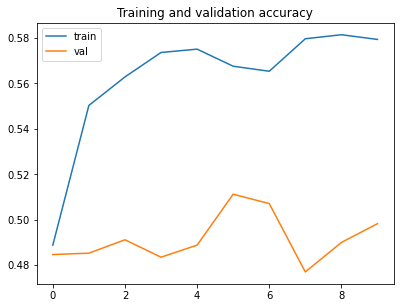

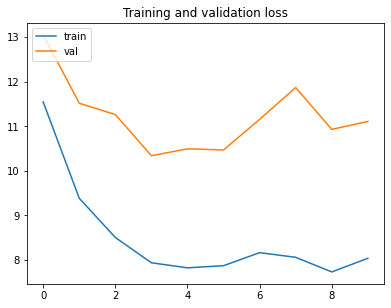

In [30]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')

In [65]:
model2 = keras.Sequential([
    keras.layers.Dense(8, input_dim=input_shape, activation=tf.nn.relu), 
    keras.layers.Dense(4, activation=tf.nn.relu), 
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model2.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 8)                 458760    
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 5         
Total params: 458,801
Trainable params: 458,801
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model2.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6776 samples, validate on 1694 samples
Epoch 1/20
6776/6776 [==============================] - 19s 3ms/sample - loss: 11.8764 - accuracy: 0.5481 - val_loss: 9.2173 - val_accuracy: 0.5986
Epoch 2/20
6776/6776 [==============================] - 5s 731us/sample - loss: 5.2271 - accuracy: 0.6648 - val_loss: 6.8565 - val_accuracy: 0.6387
Epoch 3/20
6776/6776 [==============================] - 3s 500us/sample - loss: 2.7210 - accuracy: 0.7218 - val_loss: 5.5554 - val_accuracy: 0.6558
Epoch 4/20
6776/6776 [==============================] - 3s 422us/sample - loss: 1.5923 - accuracy: 0.7534 - val_loss: 4.7370 - val_accuracy: 0.6706
Epoch 5/20
6776/6776 [==============================] - 3s 482us/sample - loss: 1.0973 - accuracy: 0.7698 - val_loss: 4.5936 - val_accuracy: 0.6860
Epoch 6/20
6776/6776 [==============================] - 3s 507us/sample - loss: 0.9962 - accuracy: 0.7744 - val_loss: 4.2140 - val_accuracy: 0.7025
Epoch 7/20
6776/6776 [==============================] - 3s 430us

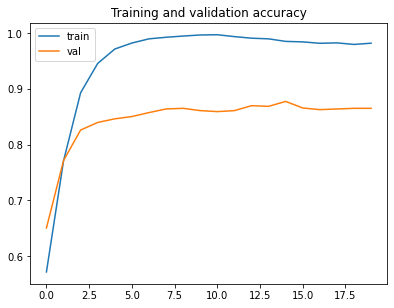

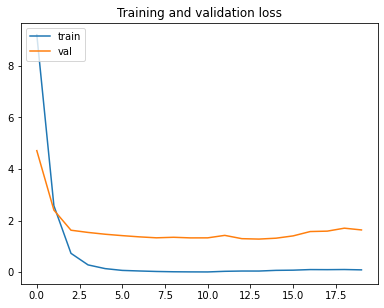

In [63]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')